In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

In [2]:
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values)) 
    
def metric_and_reference_start_plot():
    global metric_values, multires_iterations
    global min_values, max_values, mean_values
    global current_iteration, cumul_iter
    
    metric_values = []
    multires_iterations = []
    mean_values = []
    min_values = []
    max_values = []
    current_iteration = -1
    cumul_iter = 0
    
def metric_and_reference_stop_plot():
    global metric_values, multires_iterations
    global min_values, max_values, mean_values
    global current_iteration, cumul_iter
    
    plt.close()
    
def metric_and_reference_plot_values(registration_method, fixed_points, moving_points):
    global metric_values, multires_iterations
    global min_values, max_values, mean_values
    global current_iteration, cumul_iter
    
    if registration_method.GetOptimizerIteration() == current_iteration:
        return
    
    cumul_iter = len(metric_values)
    current_iteration = registration_method.GetOptimizerIteration()
    metric_values.append(registration_method.GetMetricValue())
    
    current_transform = sitk.CompositeTransform(registration_method.GetInitialTransform())
    current_transform.SetParameters(registration_method.GetOptimizerPosition())
    current_transform.AddTransform(registration_method.GetMovingInitialTransform())
    current_transform.AddTransform(registration_method.GetFixedInitialTransform().GetInverse())
    
    if current_iteration % 10 == 0:
        currentImageResampled = sitk.Resample(movingImage, fixedImage, current_transform, sitk.sitkLinear, 0.0, 
                                              movingImage.GetPixelID())
        clear_output(wait=True)
        plt.imshow(sitk.GetArrayViewFromImage(currentImageResampled)[0, ...], cmap="gray")
        plt.imshow(sitk.GetArrayViewFromImage(fixedImage)[0, ...], cmap="gray", alpha=0.5)
        plt.axis("off")
        plt.title(f"Aktuální iterace: {current_iteration}\nKumulativní iterace: {cumul_iter}", fontsize=10)
        plt.show()
    
    mean_error, _, min_error, max_error, _ = getRegistrationErrors(current_transform, fixed_points, moving_points)
    
    mean_values.append(mean_error)
    min_values.append(min_error)
    max_values.append(max_error)
    
def getPoints(path):
    pointList = []
    with open(path, "r") as pointsFile:
        [pointList.append(line.split(",")[1:4]) for line in pointsFile.readlines()[1:]]
        pointList = [[float(coords) for coords in sublist] for sublist in pointList]
        return pointList
    
def getRegistrationErrors(transform, fixed_points, moving_points):
    inverseTransform = transform.GetInverse()
    transformed_points = [inverseTransform.TransformPoint(p) for p in moving_points]
    errors = [np.linalg.norm(np.array(p_fixed) - np.array(p_moving)) 
              for p_fixed, p_moving in zip(fixed_points, transformed_points)]
    
    return np.mean(errors), np.std(errors), np.min(errors), np.max(errors), errors

def plotRegistrationErrors():
    figMetric, axMetric = plt.subplots(1, 1)
    axMetric.plot(np.arange(0, len(metric_values)), metric_values, "#1f77b4")
    axMetric.plot(multires_iterations, [metric_values[index] for index in multires_iterations], marker="o", 
                  label="Registrační úroveň", linestyle="none", 
                  markeredgecolor="none", markersize=6., c="#ff7f0e")
    axMetric.set_xlabel("Počet iterací [-]", fontsize=11)
    axMetric.set_ylabel("Vzájemná informace [-]", fontsize=11)
    axMetric.legend()
    axMetric.set_title("Optimalizace podobnostní metriky")
    
    # Plot the TRE mean value and the [min-max] range.
    figTre, axTre = plt.subplots(1, 1)
    axTre.plot(mean_values, color="black", label="Průměr")
    axTre.fill_between(range(len(mean_values)), min_values, max_values,
                     facecolor="red", alpha=0.5)
    axTre.set_xlabel("Počet iterací", fontsize=11)
    axTre.set_ylabel("Rozdíl vzdáleností (TRE) [mm]", fontsize=11)
    axTre.set_title("Míra nepřesnosti registrace")
    axTre.legend()

    # Adjust the spacing between subplots so that the axis labels don't overlap.
    plt.show()

Fixed image, spacing: (1.0, 1.0, 0.25), size: (1000, 1000, 4),direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0), origin: (0.0, 0.0, -0.375)
Moving image, spacing: (1.0, 1.0, 0.25), size: (1000, 1000, 4),direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0), origin: (0.0, 0.0, -0.375)


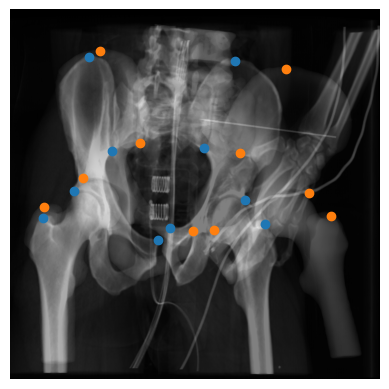

In [3]:
num = "02"
movingImage = sitk.ReadImage(f"input_files\\pacient_{num}\\registration\\pacient{num}PreopAP.mha", sitk.sitkFloat32)
fixedImage = sitk.ReadImage(f"input_files\\pacient_{num}\\registration\\pacient{num}IntraopAPST.mha", sitk.sitkFloat32)

movingPoints = getPoints(f"input_files\\pacient_{num}\\registration\\pacient{num}PreopPointsAP.csv")
fixedPoints = getPoints(f"input_files\\pacient_{num}\\registration\\pacient{num}IntraopPointsAP.csv")

print(f"Fixed image, spacing: {fixedImage.GetSpacing()}, size: {fixedImage.GetSize()},"
      f"direction: {fixedImage.GetDirection()}, origin: {fixedImage.GetOrigin()}")
print(f"Moving image, spacing: {movingImage.GetSpacing()}, size: {movingImage.GetSize()},"
      f"direction: {movingImage.GetDirection()}, origin: {movingImage.GetOrigin()}")
plt.imshow(sitk.GetArrayViewFromImage(fixedImage)[0, ...], cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(movingImage)[0, ...], cmap="gray", alpha=0.5)
plt.scatter(list(np.array(fixedPoints).T)[0], list(np.array(fixedPoints).T)[1], c="#1f77b4")
plt.scatter(list(np.array(movingPoints).T)[0], list(np.array(movingPoints).T)[1], c="#ff7f0e")
plt.axis("off")
plt.show()

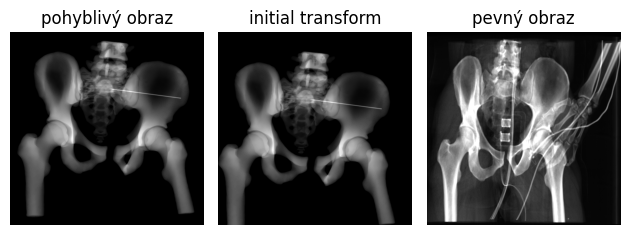

In [4]:
initialTransform = sitk.CenteredTransformInitializer(fixedImage, movingImage,
                                                     sitk.AffineTransform(3),
                                                     sitk.CenteredTransformInitializerFilter.MOMENTS)

initialImage = sitk.Resample(movingImage, fixedImage, initialTransform, sitk.sitkLinear, 0.0, movingImage.GetPixelID())

fig3, ax2 = plt.subplots(1, 3)
ax2[0].imshow(sitk.GetArrayViewFromImage(movingImage)[0, ...], cmap="gray")
ax2[1].imshow(sitk.GetArrayViewFromImage(initialImage)[0, ...], cmap="gray")
ax2[2].imshow(sitk.GetArrayViewFromImage(fixedImage)[0, ...], cmap="gray")
ax2[0].set_title("pohyblivý obraz")
ax2[1].set_title("initial transform")
ax2[2].set_title("pevný obraz")
ax2[0].axis("off")
ax2[1].axis("off")
ax2[2].axis("off")
fig3.tight_layout()
plt.show()

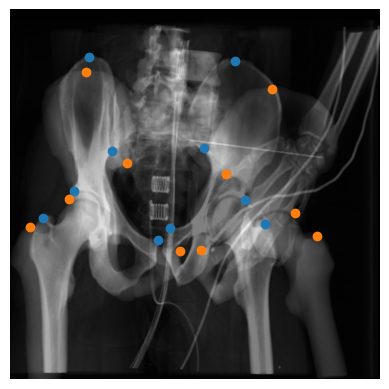

In [5]:
initialTransformInverse = initialTransform.GetInverse()
movingInitialPoints = [initialTransformInverse.TransformPoint(p) for p in movingPoints]

plt.imshow(sitk.GetArrayViewFromImage(fixedImage)[0, ...], cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(initialImage)[0, ...], cmap="gray", alpha=0.5)
plt.scatter(list(np.array(fixedPoints).T)[0], list(np.array(fixedPoints).T)[1], c="#1f77b4")
# plt.scatter(list(np.array(movingPoints).T)[0], list(np.array(movingPoints).T)[1], c="r")
plt.scatter(list(np.array(movingInitialPoints).T)[0], list(np.array(movingInitialPoints).T)[1], c="#ff7f0e")
plt.axis("off")
plt.show()

In [8]:
levels = 5
shrinkFactor = [2 * factor for factor in range(1, levels)][::-1] # 2 ** factor, range(0, levels)
shrinkFactor.append(1)
smoothFactor = [2 * factor for factor in range(0, levels)][::-1] # range(0, levels)


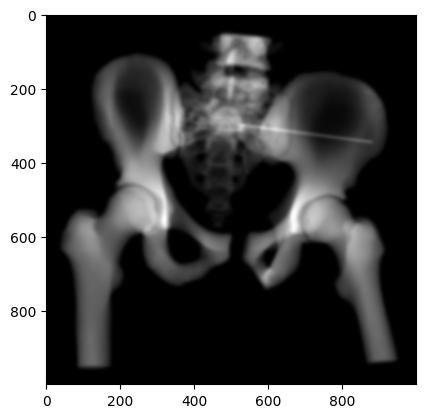

In [9]:
smoothed = sitk.SmoothingRecursiveGaussian(movingImage[..., 0], 4)
plt.imshow(sitk.GetArrayViewFromImage(smoothed), cmap="gray")

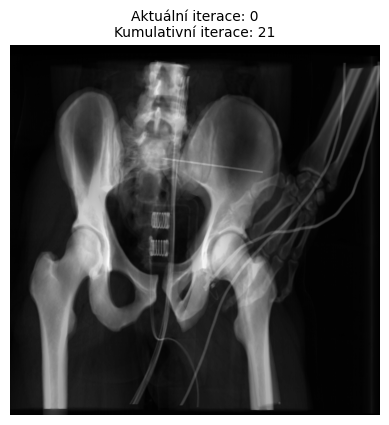

Doba trvání: 69.82047271728516
Optimizer stop condition: A rounding error occurred or line-search steps have an insufficient reduction
Iteration: 6
Metric value: -0.4567790823803233
Mean TRE: 17.5839753993372


In [10]:
registration = sitk.ImageRegistrationMethod()
registration.SetMetricAsMattesMutualInformation(50)
registration.SetOptimizerScalesFromPhysicalShift()
# registration.SetOptimizerAsGradientDescent(learningRate=1.0,
#                                            numberOfIterations=200,
#                                            convergenceMinimumValue=1e-5,
#                                            convergenceWindowSize=5,
#                                            estimateLearningRate=registration.EachIteration)

# registration.SetOptimizerAsGradientDescentLineSearch(learningRate=1.0,
#                                                      numberOfIterations=15,
#                                                      convergenceMinimumValue=1e-5,
#                                                      convergenceWindowSize=5,
#                                                      lineSearchMaximumIterations=4)

registration.SetOptimizerAsLBFGS2(numberOfIterations=30, 
                                  hessianApproximateAccuracy=4,
                                  lineSearchAccuracy=1e-4,
                                  lineSearchMinimumStep=1e-20,
                                  lineSearchMaximumStep=1e20)
registration.SetMetricSamplingStrategy(sitk.ImageRegistrationMethod.NONE)
registration.SetMetricSamplingPercentage(percentage=0.01, seed=42)
registration.SetInitialTransform(initialTransform, inPlace=False)
registration.SetInterpolator(sitk.sitkLinear)
registration.SetShrinkFactorsPerLevel(shrinkFactors=shrinkFactor)
registration.SetSmoothingSigmasPerLevel(smoothingSigmas=smoothFactor)
registration.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

registration.AddCommand(sitk.sitkStartEvent, metric_and_reference_start_plot)
registration.AddCommand(sitk.sitkEndEvent, metric_and_reference_stop_plot)
registration.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations)
registration.AddCommand(sitk.sitkIterationEvent, lambda: metric_and_reference_plot_values(registration,
                                                                                          fixedPoints,
                                                                                          movingPoints))
start_time = time.time()
outTransform = registration.Execute(fixedImage, movingImage)
print(f"Doba trvání: {time.time() - start_time}")
print(f"Optimizer stop condition: {registration.GetOptimizerStopConditionDescription()}")
print(f"Iteration: {registration.GetOptimizerIteration()}")
print(f"Metric value: {registration.GetMetricValue()}")
print(f"Mean TRE: {mean_values[-1]}")

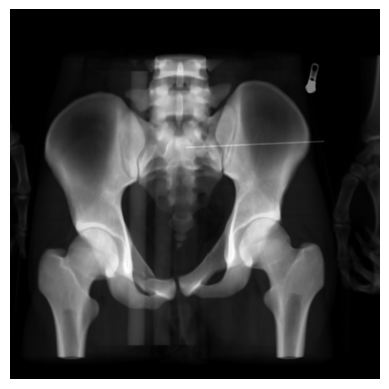

In [9]:
movingImageResampled = sitk.Resample(movingImage, fixedImage, outTransform, sitk.sitkLinear, 0.0, movingImage.GetPixelID())

plt.imshow(sitk.GetArrayViewFromImage(fixedImage)[0, ...], cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(movingImageResampled)[0, ...], cmap="gray", alpha=0.5)
plt.axis("off")
plt.show()

In [10]:
outTransformInverse = outTransform.GetInverse()
movingFinalPoints = [outTransformInverse.TransformPoint(p) for p in movingPoints]

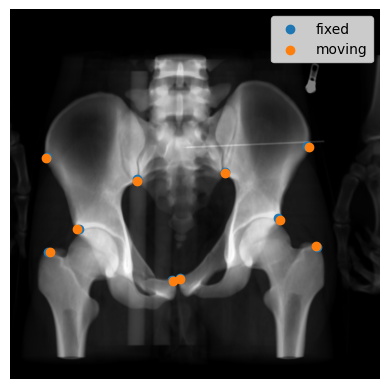

In [11]:
plt.imshow(sitk.GetArrayViewFromImage(movingImageResampled)[0, ...], cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(fixedImage)[0, ...], cmap="gray", alpha=0.5)
plt.scatter(list(np.array(fixedPoints).T)[0], list(np.array(fixedPoints).T)[1], 
            c="#1f77b4", label="fixed")
plt.scatter(list(np.array(movingFinalPoints).T)[0], list(np.array(movingFinalPoints).T)[1], 
            c="#ff7f0e", label="moving")
plt.legend()
plt.axis("off")
plt.show()

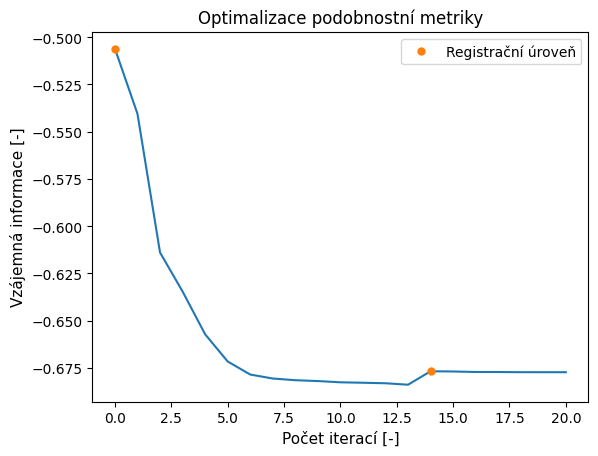

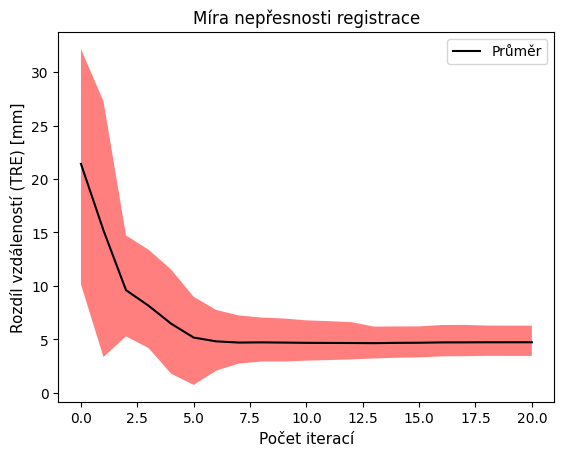

In [12]:
plotRegistrationErrors()

In [12]:
(pre_mean_error, pre_std_error, pre_min_error, 
 pre_max_error, pre_error) = getRegistrationErrors(sitk.Transform(), fixedPoints, movingPoints)
                              
(initial_mean_error, initial_std_error, initial_min_error, 
 initial_max_error, initial_error) = getRegistrationErrors(initialTransform, fixedPoints, movingPoints)

(final_mean_error, final_std_error, final_min_error, 
 final_max_error, final_error) = getRegistrationErrors(outTransform, fixedPoints, movingPoints)

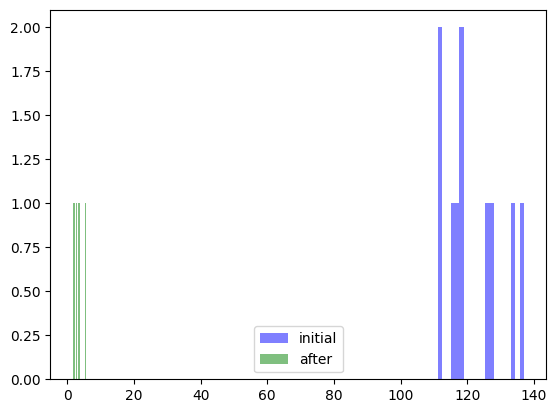

In [19]:
plt.hist(pre_error, bins=20, alpha=0.5, label="initial", color="blue")
plt.hist(final_error, bins=20, alpha=0.5, label="after", color="green")
plt.legend()

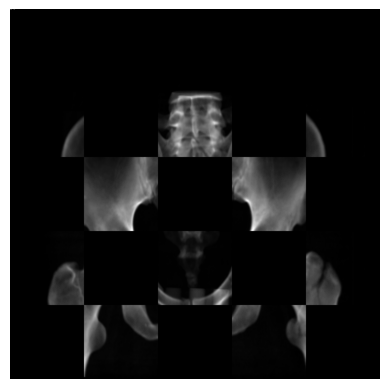

In [26]:
movingImageVis = movingImageResampled[..., 0]
fixedImageVis = fixedImage[..., 0]

movingImageResampled255 = sitk.Cast(sitk.IntensityWindowing(movingImageVis, 
                                                            windowMinimum=0., windowMaximum=32767., 
                                                            outputMinimum=0., outputMaximum=255.), 
                                                            sitk.sitkUInt8)
fixedImage255 = sitk.Cast(sitk.IntensityWindowing(sitk.RescaleIntensity(fixedImageVis, 0, 32767), 
                                                windowMinimum=0., windowMaximum=32767., 
                                                outputMinimum=0., outputMaximum=255.), 
                                                sitk.sitkUInt8)
plt.imshow(sitk.GetArrayViewFromImage(sitk.CheckerBoard(movingImageResampled255, fixedImage255, [5,5])), 
           cmap="gray")
plt.axis("off")
plt.show()

#### Test detekce hran pro vizualizaci registrace

In [ ]:
sitkImageEdges = sitk.CannyEdgeDetection(fixedImage[..., 0], lowerThreshold=0., upperThreshold=0.8)
plt.imshow(sitk.GetArrayViewFromImage(movingImageResampled255), cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(sitkImageEdges), cmap="hot", alpha=0.5)

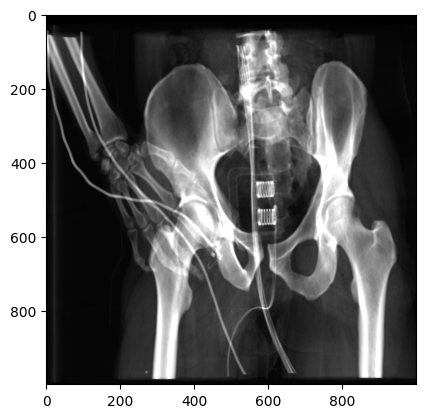

((0.4789999999999995, 0.3583999999999999, 1.0),
 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0),
 (249.032, 130.5325, -857.8500000000004))

In [8]:
num = "02"
fixedImage = sitk.ReadImage(f"input_files\\pacient_{num}\\registration\\pacient{num}IntraopAPST.mha")
plt.imshow(sitk.GetArrayViewFromImage(fixedImage)[0, ...], cmap="gray")
plt.show()
fixedImage.GetSpacing(), fixedImage.GetDirection(), fixedImage.GetOrigin()

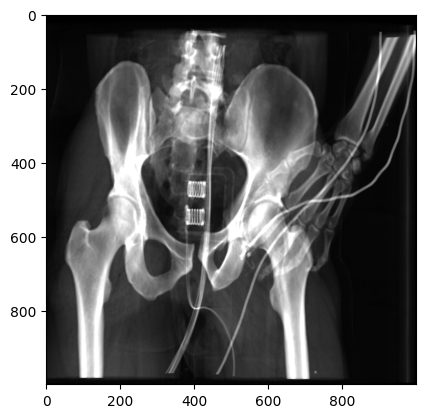

In [9]:
fixedImage = sitk.Flip(fixedImage, [True, False, False])
plt.imshow(sitk.GetArrayViewFromImage(fixedImage)[0, ...], cmap="gray")
plt.show()

In [10]:
fixedImage.SetOrigin((0.0, 0.0, 0.0))
fixedImage.SetSpacing((1.0, 1.0, 1.0))
fixedImage = sitk.Expand(fixedImage, [1, 1, 4])
fixedImage.SetDirection((1.0, 0.0, 0.0,
                         0.0, 1.0, 0.0,
                         0.0, 0.0, 1.0))
fixedImage.GetSize(), fixedImage.GetSpacing(), fixedImage.GetDirection(), fixedImage.GetOrigin()

((1000, 1000, 4),
 (1.0, 1.0, 0.25),
 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0),
 (0.0, 0.0, -0.375))

In [11]:
sitk.WriteImage(fixedImage, f"input_files\\pacient_{num}\\registration\\pacient{num}IntraopAPST.mha")